In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [3]:
df = pd.read_csv("/content/processed_race_dataset.csv")
feature_cols = [c for c in df.columns if c != 'Target']
X = df[feature_cols]
y = df['Target']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
xgb = XGBClassifier(n_estimators=200, use_label_encoder=False, eval_metric='mlogloss', random_state=42)

In [6]:
ensemble = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb)],
    voting='soft'  # soft voting uses predicted probabilities
)

ensemble.fit(X_train, y_train)
y_pred = ensemble.predict(X_test)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:53:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [7]:
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"✅ Ensemble Accuracy: {acc:.4f}")
print("Confusion Matrix:")
print(cm)

✅ Ensemble Accuracy: 0.9222
Confusion Matrix:
[[12651   605    40     0     9     0     0     0     0     2]
 [  876 10905   341     0    14     3     1     0     0     0]
 [  170   620  5367     1     3    24    26     0     0     0]
 [    0     1     3   169     0     0     3     0     0     0]
 [    1     5     2     0  1931     0     0     0     4     0]
 [    0     6    18     0     0  1175     4     0     0     0]
 [    0     4    23     0     0    11   860     0     0     0]
 [    0     0     0     0     0     0     0     8     0     0]
 [    0     1     0     0     3     0     0     0   156     0]
 [    0     0     0     0     0     0     0     0     0   255]]


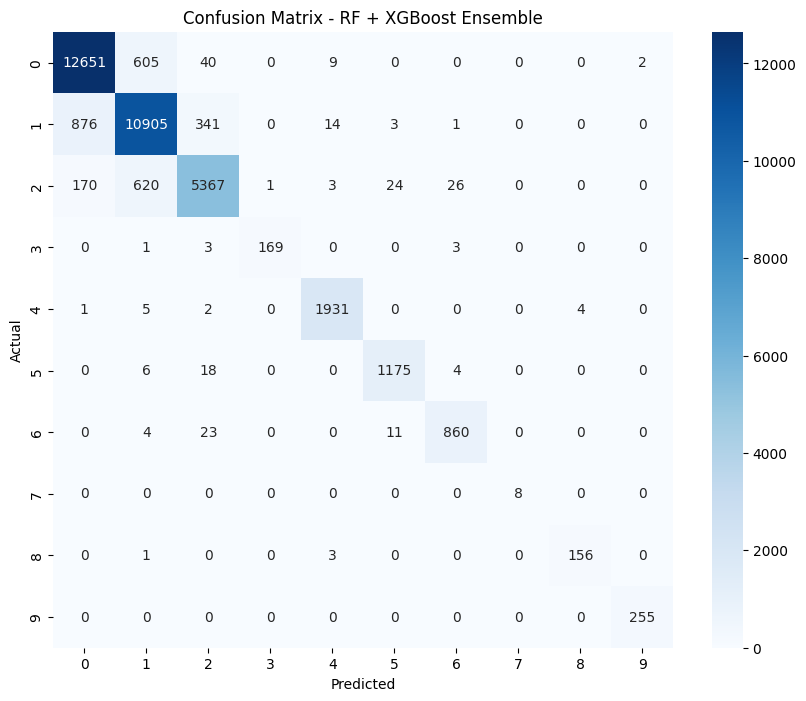

In [8]:
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - RF + XGBoost Ensemble')
plt.show()

In [9]:
joblib.dump(ensemble, "rf_xgb_ensemble.pkl")

['rf_xgb_ensemble.pkl']

RF + XGBOOST ends here, downwards, lstm + nn

In [75]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [60]:
df = pd.read_csv("/content/processed_race_dataset.csv")

In [76]:
feature_cols = ['LapNumber', 'Stint', 'AirTemp_C', 'TrackTemp_C', 'Rainfall',
                'DriverEncoded', 'EventNameEncoded']
X = df[feature_cols].values
y = df['Target'].values

In [77]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [78]:
def create_sequences(X, y, seq_len=15):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len + 1):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len-1])  # target = last lap in sequence
    return np.array(X_seq), np.array(y_seq)

In [80]:
seq_len = 15
X_seq, y_seq = create_sequences(X_scaled, y, seq_len)
print("Sequence shape:", X_seq.shape, y_seq.shape)  # (samples, 15, features)

Sequence shape: (181487, 15, 7) (181487,)


In [81]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_acc = []

In [82]:
for fold, (train_idx, val_idx) in enumerate(skf.split(X_seq, y_seq)):
    print(f"\n🔹 Fold {fold+1}")

    X_train, X_val = X_seq[train_idx], X_seq[val_idx]
    y_train, y_val = y_seq[train_idx], y_seq[val_idx]
    model = Sequential()
    model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(len(np.unique(y)), activation='softmax'))  # output = num classes

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    es = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
    rlrop = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-5)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=128,
        callbacks=[es, rlrop],
        verbose=1
    )

    val_acc = model.evaluate(X_val, y_val, verbose=0)[1]
    fold_acc.append(val_acc)
    print(f"Fold {fold+1} Accuracy: {val_acc:.4f}")

    y_pred = np.argmax(model.predict(X_val), axis=1)
    print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

print("\n✅ Mean LSTM + NN Accuracy:", np.mean(fold_acc))


🔹 Fold 1


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.4842 - loss: 1.2980 - val_accuracy: 0.6111 - val_loss: 0.9238 - learning_rate: 0.0010
Epoch 2/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.6179 - loss: 0.9014 - val_accuracy: 0.6678 - val_loss: 0.7759 - learning_rate: 0.0010
Epoch 3/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.6723 - loss: 0.7676 - val_accuracy: 0.7059 - val_loss: 0.6837 - learning_rate: 0.0010
Epoch 4/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.6988 - loss: 0.7026 - val_accuracy: 0.7236 - val_loss: 0.6478 - learning_rate: 0.0010
Epoch 5/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.7126 - loss: 0.6653 - val_accuracy: 0.7345 - val_loss: 0.6199 - learning_rate: 0.0010
Epoch 6/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.7269 - loss: 0.6324 - val_accuracy: 0.7486 - val_loss: 0.5879 - learning_rate: 0.0010
Epoch 7/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.74

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.4960 - loss: 1.2837 - val_accuracy: 0.6157 - val_loss: 0.9044 - learning_rate: 0.0010
Epoch 2/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.6282 - loss: 0.8672 - val_accuracy: 0.6740 - val_loss: 0.7674 - learning_rate: 0.0010
Epoch 3/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.6815 - loss: 0.7488 - val_accuracy: 0.7106 - val_loss: 0.6773 - learning_rate: 0.0010
Epoch 4/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.7079 - loss: 0.6872 - val_accuracy: 0.7224 - val_loss: 0.6481 - learning_rate: 0.0010
Epoch 5/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.7216 - loss: 0.6476 - val_accuracy: 0.7414 - val_loss: 0.6084 - learning_rate: 0.0010
Epoch 6/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.7365 - loss: 0.6194 - val_accuracy: 0.7493 - val_loss: 0.5932 - learning_rate: 0.0010
Epoch 7/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.74

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.4980 - loss: 1.2814 - val_accuracy: 0.6235 - val_loss: 0.8823 - learning_rate: 0.0010
Epoch 2/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.6308 - loss: 0.8685 - val_accuracy: 0.6776 - val_loss: 0.7537 - learning_rate: 0.0010
Epoch 3/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.6741 - loss: 0.7616 - val_accuracy: 0.7064 - val_loss: 0.6852 - learning_rate: 0.0010
Epoch 4/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.7006 - loss: 0.6961 - val_accuracy: 0.7146 - val_loss: 0.6646 - learning_rate: 0.0010
Epoch 5/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.7178 - loss: 0.6582 - val_accuracy: 0.7311 - val_loss: 0.6251 - learning_rate: 0.0010
Epoch 6/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.7289 - loss: 0.6302 - val_accuracy: 0.7488 - val_loss: 0.5853 - learning_rate: 0.0010
Epoch 7/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.74

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.4821 - loss: 1.2977 - val_accuracy: 0.6177 - val_loss: 0.9068 - learning_rate: 0.0010
Epoch 2/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.6247 - loss: 0.8878 - val_accuracy: 0.6842 - val_loss: 0.7468 - learning_rate: 0.0010
Epoch 3/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.6819 - loss: 0.7509 - val_accuracy: 0.7024 - val_loss: 0.6994 - learning_rate: 0.0010
Epoch 4/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.7021 - loss: 0.6965 - val_accuracy: 0.7253 - val_loss: 0.6363 - learning_rate: 0.0010
Epoch 5/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.7175 - loss: 0.6540 - val_accuracy: 0.7349 - val_loss: 0.6134 - learning_rate: 0.0010
Epoch 6/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.7324 - loss: 0.6202 - val_accuracy: 0.7480 - val_loss: 0.5872 - learning_rate: 0.0010
Epoch 7/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.746

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.4912 - loss: 1.2974 - val_accuracy: 0.6182 - val_loss: 0.9034 - learning_rate: 0.0010
Epoch 2/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.6253 - loss: 0.8770 - val_accuracy: 0.6721 - val_loss: 0.7732 - learning_rate: 0.0010
Epoch 3/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.6670 - loss: 0.7707 - val_accuracy: 0.7007 - val_loss: 0.6922 - learning_rate: 0.0010
Epoch 4/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.6959 - loss: 0.7055 - val_accuracy: 0.7161 - val_loss: 0.6583 - learning_rate: 0.0010
Epoch 5/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.7110 - loss: 0.6714 - val_accuracy: 0.7309 - val_loss: 0.6255 - learning_rate: 0.0010
Epoch 6/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.7254 - loss: 0.6375 - val_accuracy: 0.7419 - val_loss: 0.5986 - learning_rate: 0.0010
Epoch 7/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.73

Graph to check overfitting or no

In [83]:
all_histories = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_seq, y_seq)):
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=128,
        callbacks=[es, rlrop],
        verbose=1
    )
    all_histories.append(history)


Epoch 1/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9040 - loss: 0.2365 - val_accuracy: 0.8802 - val_loss: 0.3306 - learning_rate: 0.0010
Epoch 2/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9057 - loss: 0.2353 - val_accuracy: 0.8776 - val_loss: 0.3349 - learning_rate: 0.0010
Epoch 3/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9062 - loss: 0.2345 - val_accuracy: 0.8829 - val_loss: 0.3290 - learning_rate: 0.0010
Epoch 4/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9099 - loss: 0.2252 - val_accuracy: 0.8798 - val_loss: 0.3392 - learning_rate: 0.0010
Epoch 5/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.9087 - loss: 0.2246 - val_accuracy: 0.8830 - val_loss: 0.3249 - learning_rate: 0.0010
Epoch 6/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.9123 - loss: 0.2199 - val_accuracy: 0.8843 - val_loss: 0.3330 - learning_rate: 0.0010
Epoch 7/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0

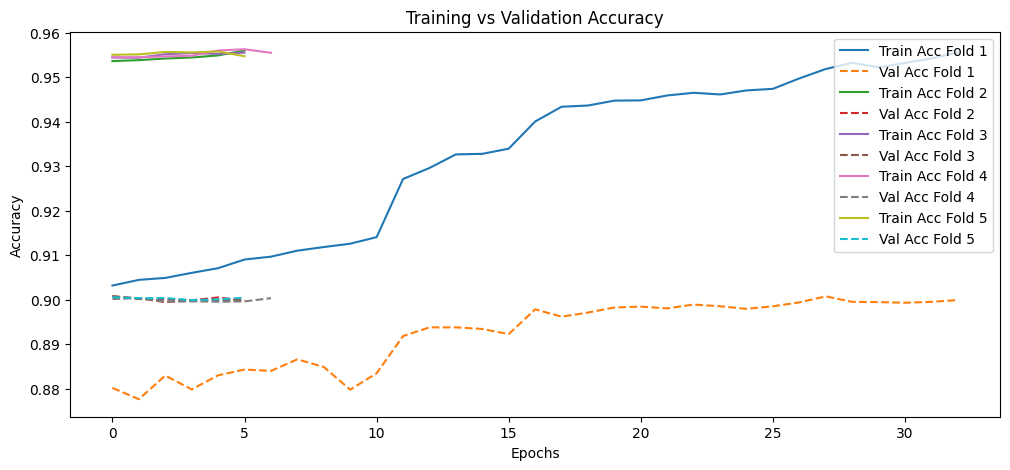

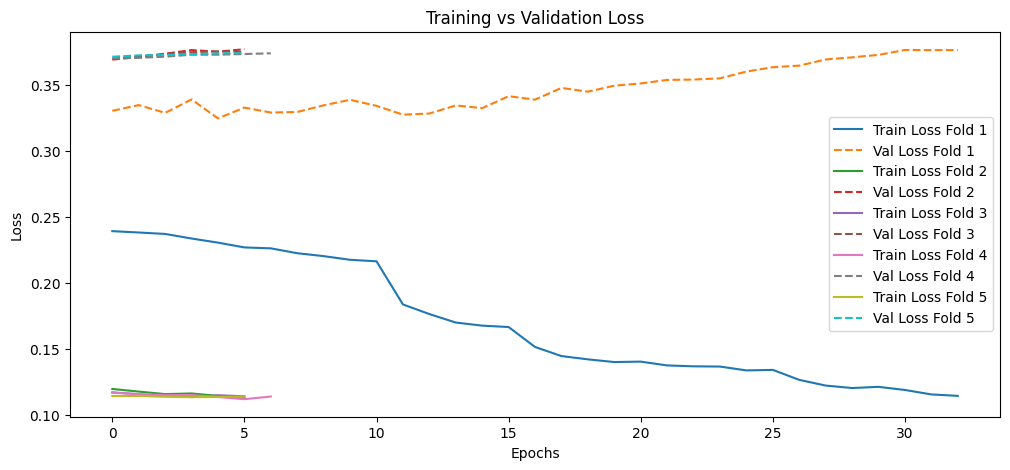

In [84]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(12,5))
for i, history in enumerate(all_histories):
    plt.plot(history.history['accuracy'], label=f'Train Acc Fold {i+1}')
    plt.plot(history.history['val_accuracy'], '--', label=f'Val Acc Fold {i+1}')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.figure(figsize=(12,5))
for i, history in enumerate(all_histories):
    plt.plot(history.history['loss'], label=f'Train Loss Fold {i+1}')
    plt.plot(history.history['val_loss'], '--', label=f'Val Loss Fold {i+1}')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [86]:
# Save in native Keras format
model_save_path = "/content/lstm_nn_model.keras"
model.save(model_save_path)
print(f"✅ Model saved at: {model_save_path}")

✅ Model saved at: /content/lstm_nn_model.keras
